<a href="https://colab.research.google.com/github/seunghoonss/AI-HACKATHON/blob/main/%EB%B0%98%EB%A0%A4%EA%B2%AC_%EA%B2%B0%EB%A7%89%EC%97%BC_%EC%A7%84%EB%8B%A8_%EB%B3%B4%EC%A1%B0_%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 반려견 결막염 진단 보조 및 시각화 인공지능

> [빵형의 개발도상국](https://www.youtube.com/@bbanghyong)

## 데이터셋

### 반려동물 안구 질환 데이터 - AI허브

https://www.aihub.or.kr/aihubdata/data/view.do?dataSetSn=562

![](https://i.imgur.com/WRKXXS3.png)

## 데이터셋 다운로드 및 압축해제

- 샘플데이터 600장
  - 정상(Negative): 300장
  - 결막염(Positive): 300장

In [ ]:
!wget https://github.com/kairess/toy-datasets/raw/master/dog-inflammation.zip
!unzip -q dog-inflammation.zip

--2023-01-15 12:37:48--  https://github.com/kairess/toy-datasets/raw/master/dog-inflammation.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kairess/toy-datasets/master/dog-inflammation.zip [following]
--2023-01-15 12:37:48--  https://raw.githubusercontent.com/kairess/toy-datasets/master/dog-inflammation.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4592449 (4.4M) [application/zip]
Saving to: ‘dog-inflammation.zip’

dog-inflammation.zi 100%[===================>]   4.38M  --.-KB/s    in 0.03s   

2023-01-15 12:37:49 (139 MB/s) - ‘dog-inflammation.zip’ saved [4592449/4592449]



## 데이터 로더

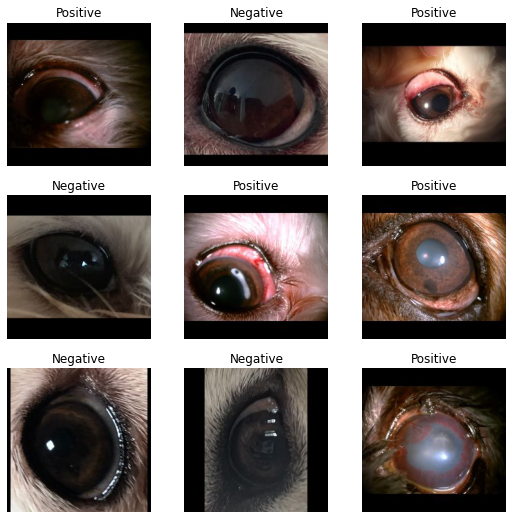

In [ ]:
from fastai.vision.all import *

path = 'dog-inflammation'

block = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    get_y = parent_label,
)

loader = block.dataloaders(path)

loader.show_batch()

## 학습

Fine-tune ResNet18

In [ ]:
learn = vision_learner(loader, resnet18, metrics=accuracy)

learn.fine_tune(epochs = 3)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,0.615597,0.133484,0.958333,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.127136,0.066310,0.991667,00:02
1,0.076081,0.051574,0.991667,00:02
2,0.049671,0.055037,0.991667,00:02


## 테스트 결과

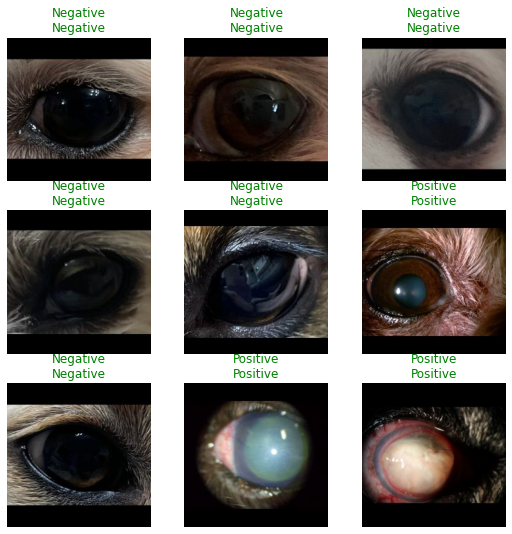

In [ ]:
learn.show_results()

## GradCAM

주요 인식 부위 시각화

torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])


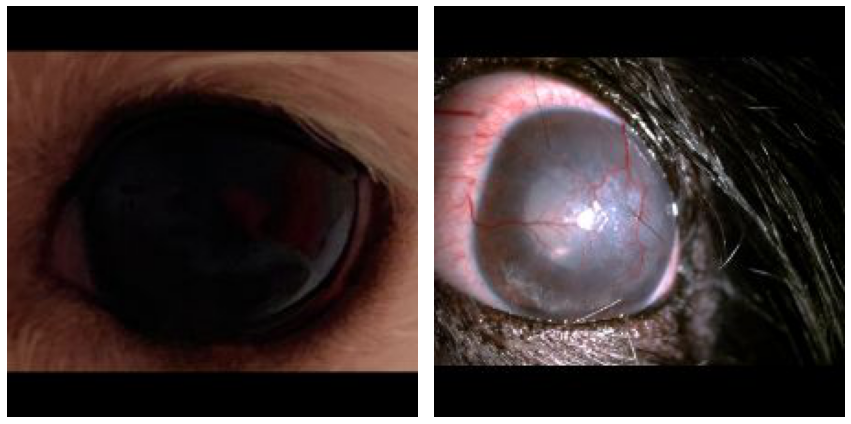

In [ ]:
neg_path = '/content/dog-inflammation/Negative/D0_03f7e7c0-60a5-11ec-8402-0a7404972c70.jpg'
pos_path = '/content/dog-inflammation/Positive/D0_02fa7d26-60a5-11ec-8402-0a7404972c70.jpg'

test_loader = loader.test_dl([neg_path, pos_path])

neg_x, pos_x = next(iter(test_loader))[0]

neg_x = neg_x.unsqueeze(0)
pos_x = pos_x.unsqueeze(0)

print(neg_x.shape, pos_x.shape)

neg_img = Image.open(neg_path)
pos_img = Image.open(pos_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(neg_img)
ax[0].axis('off')
ax[1].imshow(pos_img)
ax[1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class Hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o):
        self.stored = o.detach().clone()
    def __enter__(self, *args):
        return self
    def __exit__(self, *args):
        self.hook.remove()

class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)  
    def hook_func(self, m, gi, go):
        self.stored = go[0].detach().clone()
    def __enter__(self, *args):
        return self
    def __exit__(self, *args):
        self.hook.remove()

torch.Size([14, 14])


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


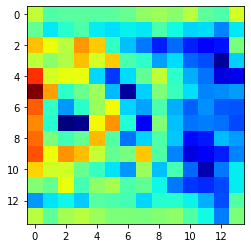

In [ ]:
def get_gradcam(x, location=-1):
    with HookBwd(learn.model[0][location]) as hookg:
        with Hook(learn.model[0][location]) as hook:
            output = learn.model.eval()(x.cuda())
            idx = torch.argmax(output)
            act = hook.stored
        output[0, idx].backward()
        grad = hookg.stored

    w = grad[0].mean(dim=[1, 2], keepdim=True)
    heatmap = (w * act[0]).sum(0).detach().cpu()

    return heatmap

heatmap = get_gradcam(pos_x, location=-2)

print(heatmap.shape)
plt.imshow(heatmap, cmap='jet')
plt.show()

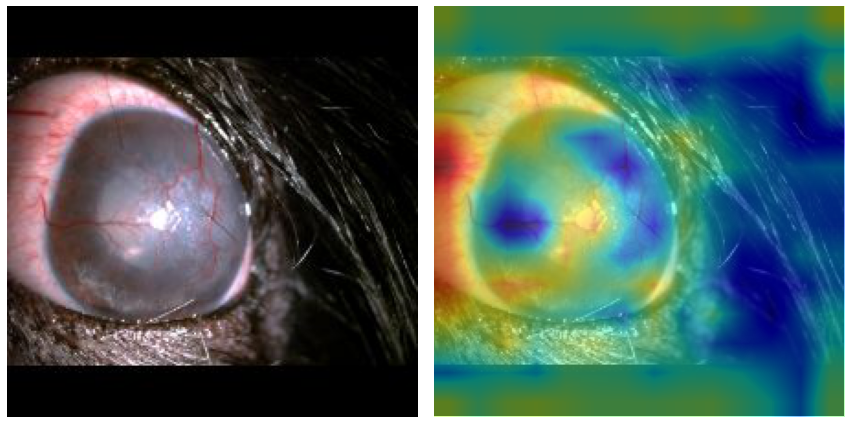

In [ ]:
img = Image.open(pos_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(img)
ax[1].imshow(heatmap.cpu(), alpha=0.5, extent=(0,224,224,0),
              interpolation='bilinear', cmap='jet')
ax[1].axis('off')
plt.tight_layout()
plt.show()

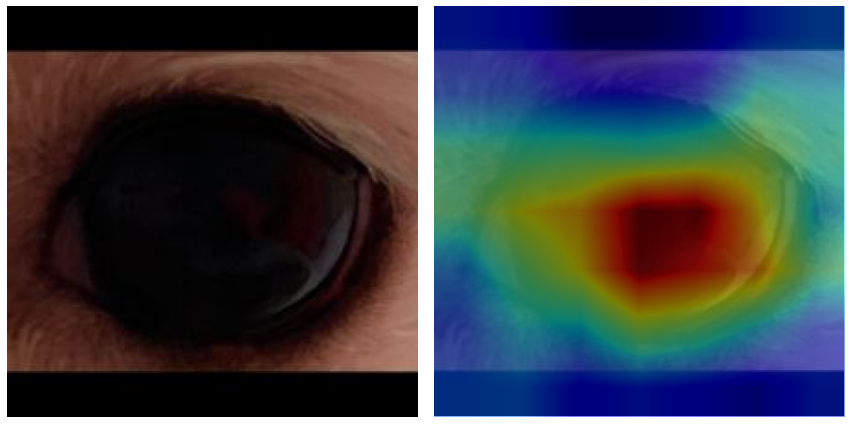

In [ ]:
heatmap = get_gradcam(neg_x, location=-1)
img = Image.open(neg_path)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(img)
ax[1].imshow(heatmap.cpu(), alpha=0.5, extent=(0,224,224,0),
              interpolation='bilinear', cmap='jet')
ax[1].axis('off')
plt.tight_layout()
plt.show()